# NLI classification

We build a ensemble of neural networks for natural language inference (NLI) classification.
In NLI, we have to determine if the premise entails, contradicts, or is neutral with respect to the hypothesis.

Examples can look like this:

---
- Premise: "A boy is jumping on skateboard in the middle of a red bridge."
- Hypothesis: "The boy skates down the sidewalk."
- Label: "contradiction"
---
- Premise: "A boy is jumping on skateboard in the middle of a red bridge."
- Hypothesis: "The boy does a skateboarding trick."
- Label: "entailment"
---
- Premise: "A boy is jumping on skateboard in the middle of a red bridge."
- Hypothesis: "The boy is wearing safety equipment."
- Label: "neutral"
---

For this notebook, we need PyTorch and the Hugging Face datasets library, in addition to the usual Scikit-learn, numpy, etc.

In [ ]:
#!pip install torch datasets tqdm scikit-learn matplotlib

If you are running this notebook locally, you can install them via pip:

```bash
python -m venv nli-ensemble
source nli-ensemble/bin/activate
pip install torch datasets scikit-learn tqdm matplotlib
```

In [1]:
from datasets import load_dataset, DatasetDict # For downloading datasets
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader
from tqdm.notebook import tqdm # Progress bars
from collections import Counter # dictionary with {item: frequency}
import matplotlib.pyplot as plt
import sklearn
import sklearn.metrics
import re # regular expressions

device = "cuda" if torch.cuda.is_available() else "cpu"

/lnet/work/people/vico/TokSurvey/.venv/lib/python3.12/site-packages/torch/cuda/__init__.py:63: FutureWarning: The pynvml package is deprecated. Please install nvidia-ml-py instead. If you did not install pynvml directly, please report this to the maintainers of the package that installed pynvml for you.
  import pynvml  # type: ignore[import]


In [2]:
device

'cuda'

## Data

Hugging Face has a large number of datasets (and pretrained models) for NLP tasks.
We will use the [SNLI dataset](https://huggingface.co/datasets/stanfordnlp/snli) for this notebook.
It has three columns: `premise`, `hypothesis`, and `label`, where the label can be one of "entails" (0), "neutral" (1), or "contradicts" (2).
The dataset is quite large for Colab (~500k samples), so we will use just a subset of it.

Alternatively, the [babi NLI dataset](https://huggingface.co/datasets/tasksource/babi_nli) is much smaller (~2k samples).
It has a similar structure, but only two labels: "entails" (1) and "not-entails" (0).

In [3]:
ds = load_dataset("stanfordnlp/snli", split=["train[:50100]","validation","test"])
ds = DatasetDict(zip(["train", "validation", "test"], ds))

# ds = load_dataset("tasksource/babi_nli", "agents-motivations") 
ds = ds.filter(lambda x: x['label'] != -1)

In [4]:
ds

DatasetDict({
    train: Dataset({
        features: ['premise', 'hypothesis', 'label'],
        num_rows: 50047
    })
    validation: Dataset({
        features: ['premise', 'hypothesis', 'label'],
        num_rows: 9842
    })
    test: Dataset({
        features: ['premise', 'hypothesis', 'label'],
        num_rows: 9824
    })
})

In [5]:
ds['train'][1]

{'premise': 'A person on a horse jumps over a broken down airplane.',
 'hypothesis': 'A person is at a diner, ordering an omelette.',
 'label': 2}

Then we need to clean the data and build a vocabulary to encode the text for the model.

First we remove non-alphanumeric characters and lowercase everything.

In [6]:
# ~50 seconds
regex = re.compile(r'[^a-z0-9 ]')
word_freq = Counter()
for i in tqdm(ds['train']):
    word_freq.update(regex.sub('', i['premise'].lower()).split())
    word_freq.update(regex.sub('', i['hypothesis'].lower()).split())
print(len(word_freq))

  0%|          | 0/50047 [00:00<?, ?it/s]

12852


Thenm, we select the most frequent words to build our vocabulary. In this way we reduce the size of the vocabulary from 35k to 8k words.


In [7]:
selected_vocab = word_freq.most_common(8000)
word_to_id = {pair[0]: id_+3 for id_, pair in enumerate(selected_vocab)} # we reserve 0,1,2 for special tokens
print("ID for the word 'the':", word_to_id['the'])

ID for the word 'the': 4


To make batches of the same length, we need to pad the sequences or truncate them.
Then we concatenate the premise and hypothesis with a special separator token in between.

In [8]:
def process_data(sample, word_to_id, max_len=300, pad=0, unk=1, sep=2):
    # Word to id
    regex = re.compile(r'[^a-z0-9 ]')

    premise = regex.sub('', sample['premise'].lower()).split()
    premise = [word_to_id.get(word, unk) for word in premise]

    hypothesis = regex.sub('', sample['hypothesis'].lower()).split()
    hypothesis = [word_to_id.get(word, unk) for word in hypothesis]
    
    # Maximum length
    premise = premise[:max_len]
    hypothesis = hypothesis[:max_len]
    
    # Padding
    premise = [pad] * (max_len - len(premise)) + premise
    hypothesis = [pad] * (max_len - len(hypothesis)) + hypothesis
    sequence = premise + [sep] + hypothesis
    sample['input_ids'] = sequence
    return sample


In [9]:
ds = ds.map(lambda x: process_data(x, word_to_id), num_proc=2)

In [10]:
ds['train'][0]

{'premise': 'A person on a horse jumps over a broken down airplane.',
 'hypothesis': 'A person is training his horse for a competition.',
 'label': 1,
 'input_ids': [0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
 

Until now, we were working with *Hugging Face* datasets, but now we need to convert them to *PyTorch* datasets.

In [11]:
train = ds['train'].with_format("torch", device=device)
test = ds['test'].with_format("torch", device=device)
val = ds['validation'].with_format("torch", device=device)

train_dl = DataLoader(train, batch_size=256, shuffle=True)
test_dl = DataLoader(test, batch_size=256)
val_dl = DataLoader(val, batch_size=256)

In [12]:
tmp_dl = DataLoader(train, batch_size=5)
tmp_batch = next(iter(tmp_dl))
tmp_batch

{'premise': ['A person on a horse jumps over a broken down airplane.',
  'A person on a horse jumps over a broken down airplane.',
  'A person on a horse jumps over a broken down airplane.',
  'Children smiling and waving at camera',
  'Children smiling and waving at camera'],
 'hypothesis': ['A person is training his horse for a competition.',
  'A person is at a diner, ordering an omelette.',
  'A person is outdoors, on a horse.',
  'They are smiling at their parents',
  'There are children present'],
 'label': tensor([1, 2, 0, 1, 0]),
 'input_ids': tensor([[   0,    0,    0,  ...,   36,    3,  369],
         [   0,    0,    0,  ..., 2710,   18,    1],
         [   0,    0,    0,  ...,    8,    3,  220],
         [   0,    0,    0,  ...,   17,   50,  815],
         [   0,    0,    0,  ...,   10,   55,  927]], device='cuda:0')}

## Model

For this task, we must consider the word order, so we will use a recurrent neural network (RNN).
The details are out of the scope of this course, but the idea is that a layer processes also the previous hidden state in addition to the current input.

We are predicting three classes, so the output layer has three neurons. The model predicts a categorical distribution: the output is a vector with the probability of each class.

In [13]:
class Model(nn.Module):
    def __init__(self, vocab_size = 8000, hidden_size=256, layers=3):
        super().__init__()
        self.embs = nn.Embedding(vocab_size + 3, hidden_size, padding_idx=0) # Id to vector representation
        self.gru = nn.GRU(hidden_size, hidden_size, layers, batch_first=True) # Recurrent layer
        self.out = nn.Linear(hidden_size, 3) # Output layer

    def forward(self, x):
        x = self.embs(x)
        rnn_out, _ = self.gru(x)
        last_hidden_state = rnn_out[:, -1, :]
        return self.out(last_hidden_state) # Logits

    def predict(self, x):
        x = self.forward(x)
        return x.argmax(dim=-1) # Class

    def prob(self, x):
        x = self.forward(x)
        return F.softmax(x, dim=-1) # Probabilities

    def log_prob(self, x):
        x = self.forward(x)
        return F.log_softmax(x, dim=-1) # Log-Probabilities


Some methods for scoring the model.

In [14]:
def plot_loss(losses: list[float], f1_scores: list[float], title = None):
    fig, ax1 = plt.subplots()
    if title is not None:
        fig.suptitle(title)
    ax1.set_xlabel('Epoch')
    ax1.set_ylabel('BCE Loss')
    ax1.plot(losses)
    ax2 = ax1.twinx()

    ax2.set_ylabel('F1 Score')
    ax2.plot(f1_scores, color='orange')
    fig.tight_layout()
    plt.show()

def score(y_true, y_pred):
    # Classification report: precision, recall, f1-score
    # target_names = ['not-entrail', 'entail'] # babi_nli
    target_names = ['entail', 'neutral', 'contradiction'] # snli
    print(sklearn.metrics.classification_report(y_true, y_pred, target_names=target_names, zero_division=0))

    # Simple metric
    print("Accuracy:", sklearn.metrics.accuracy_score(y_true, y_pred))
    print("F1-Score:", sklearn.metrics.f1_score(y_true, y_pred, zero_division=0, average='macro'))

    # Confusion matrix
    cm = sklearn.metrics.confusion_matrix(y_true, y_pred)
    disp = sklearn.metrics.ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=target_names).plot()
    plt.show()

def predict(model, dl):
    y_true = []
    y_pred = []
    model.eval()
    with torch.no_grad():
        for batch in dl:
            preds = model.predict(batch['input_ids'])
            y_true.extend(batch['label'].cpu().numpy())
            y_pred.extend(preds.cpu().numpy())
    return y_true, y_pred

def save_model(model, path): # Training can be slow, so we save the model to reuse
    torch.save(model.state_dict(), path)

def load_model(path): # When loading just set the model weights
    model = Model()
    model.load_state_dict(torch.load(path))
    return model.to(device)

def f1_score(model, dl):
    y_true, y_pred = predict(model, dl)
    return sklearn.metrics.f1_score(y_true, y_pred, zero_division=0, average='macro')


In [16]:
def train_fn(model, train_dl, val_dl, epochs=10, max_steps_per_epoch=None):
    optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)
    # optimizer = torch.optim.SGD(model.parameters(), lr=1e-3)
    criterion = nn.CrossEntropyLoss() # The inputs are logits and the class indices

    losses = []
    f1_scores = []
    tmp_loss = 0
    steps = 0
    samples = 0
    for epoch in tqdm(range(epochs), total=epochs):
        for i, batch in enumerate(train_dl):
            model.train() # Set model to training mode
            optimizer.zero_grad()
            pred = model(batch['input_ids'])
            loss = criterion(pred, batch['label'].to(device))
            loss.backward()
            optimizer.step()

            tmp_loss += loss.sum().item()
            steps += 1
            samples += batch['input_ids'].size(0)

            if max_steps_per_epoch is not None and steps >= max_steps_per_epoch:
                break

        losses.append(tmp_loss / samples)
        tmp_loss = 0                
        f1_scores.append(f1_score(model, val_dl))
        steps = 0
        samples = 0
    return model, losses, f1_scores

In [18]:
model1 = Model().to(device)
model1, losses, f1_scores = train_fn(model1, train_dl, val_dl, 20, max_steps_per_epoch=10)

  0%|          | 0/20 [00:00<?, ?it/s]

From the plot, we can see that the model is learning, and we could train for longer.

Accuracy is around 63% on the validation set. A random baseline would be around 33%.

In [ ]:
!wget 
# model1 = load_model('snli_model_1.pt')

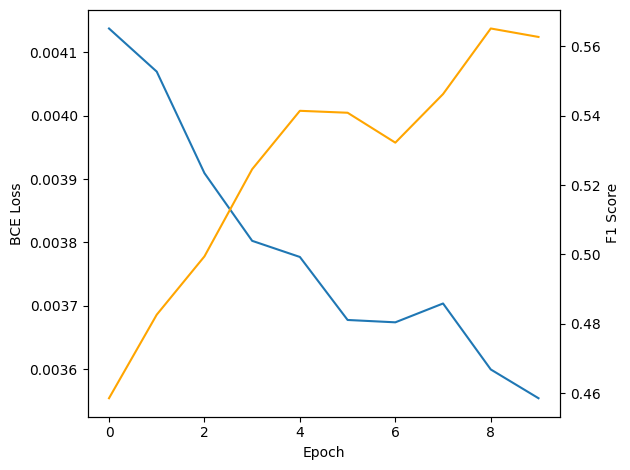

               precision    recall  f1-score   support

       entail       0.61      0.63      0.62      3368
      neutral       0.59      0.58      0.58      3219
contradiction       0.57      0.55      0.56      3237

     accuracy                           0.59      9824
    macro avg       0.59      0.59      0.59      9824
 weighted avg       0.59      0.59      0.59      9824

Accuracy: 0.587235342019544
F1-Score: 0.5864947755336484


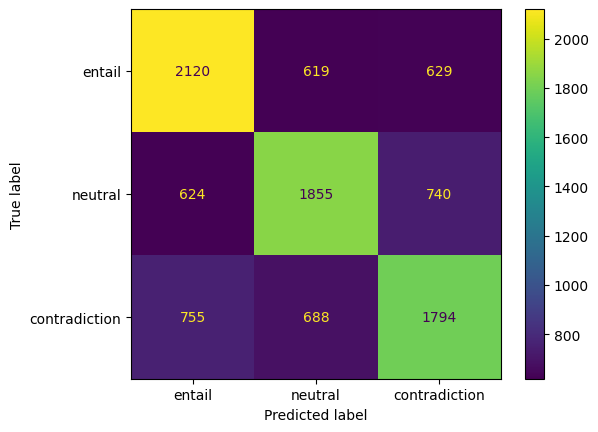

In [20]:
plot_loss(losses, f1_scores)
y_true, y_pred = predict(model1, test_dl)
score(y_true, y_pred)

We are going to reuse this model later, so better to save it.

In [ ]:
save_model(model1, 'snli_model_1.pt') # ~12MB
# model1 = load_model('snli_model_1.pt')

Since we are going to build an ensemble, we need to train multiple models.

  0%|          | 0/10 [00:00<?, ?it/s]

F1-score Model 2: 0.5768092477356652


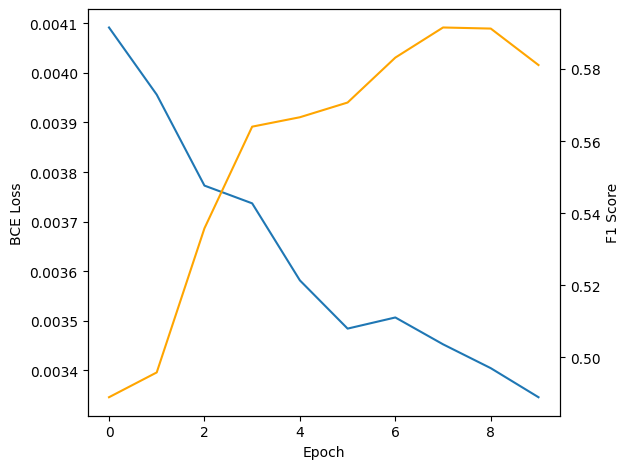

  0%|          | 0/10 [00:00<?, ?it/s]

F1-score Model 3: 0.5571234999430702


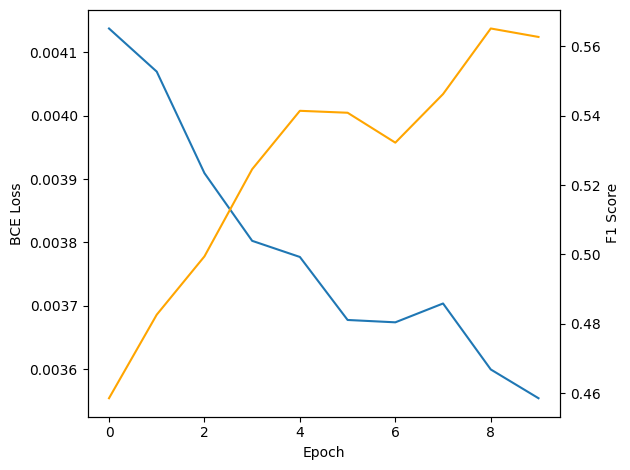

In [19]:
model2 = Model().to(device)
model2, losses, f1_scores = train_fn(model2, train_dl, val_dl, 10, max_steps_per_epoch=20)
save_model(model2, 'nli_model_2.pt')
print("F1-score Model 2:", f1_score(model2, test_dl))
plot_loss(losses, f1_scores)

model3 = Model().to(device)
model3, losses, f1_scores = train_fn(model3, train_dl, val_dl, 10, max_steps_per_epoch=10)
save_model(model3, 'nli_model_3.pt')
print("F1-score Model 3:", f1_score(model3, test_dl))
plot_loss(losses, f1_scores)

## The Ensemble

We have some pretrained models, but how do we combine their predictions?

In [21]:
def dummy_strategy(pred_batches: list[torch.Tensor]):
    pred_batch = pred_batches[0] # output of the first model
    return pred_batch.argmax(dim=-1) # most probable class

class Ensemble:
    def __init__(self, estimators: list[Model], strategy) -> None:
        self.estimators = estimators
        self.strategy = strategy
        self.eval()

    def predict(self, x):
        preds = [estimator.prob(x) for estimator in self.estimators]
        return self.strategy(preds)

    # Some torch methods that we may need
    def eval(self):
        for estimator in self.estimators:
            estimator.eval()
        return self
    def to(self, device):
        for estimator in self.estimators:
            estimator.to(device)
        return self
    def train(self):
        for estimator in self.estimators:
            estimator.train()
        return self
    
    def prob(self, x):
        preds = [estimator.prob(x) for estimator in self.estimators]
        # Average probabilities
        avg_preds = torch.stack(preds).mean(dim=0)
        return avg_preds

               precision    recall  f1-score   support

       entail       0.61      0.63      0.62      3368
      neutral       0.59      0.58      0.58      3219
contradiction       0.57      0.55      0.56      3237

     accuracy                           0.59      9824
    macro avg       0.59      0.59      0.59      9824
 weighted avg       0.59      0.59      0.59      9824

Accuracy: 0.587235342019544
F1-Score: 0.5864947755336484


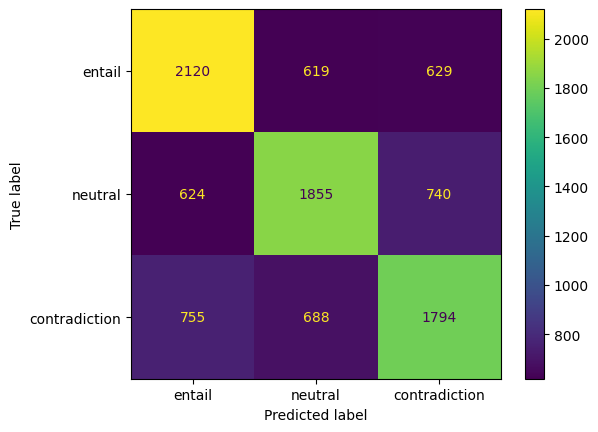

In [22]:
dummy_ensemble = Ensemble([model1, model2, model3], dummy_strategy)
y_true, y_pred = predict(dummy_ensemble, test_dl)
score(y_true, y_pred)

The first strategy was to just a placeholder that returns the prediction of the first model.
Then we can implement hard voting, where we take the class that gets the most votes from the models.

In [23]:
def majority_strategy(pred_batches: list[torch.Tensor]):
    # Get predicted classes
    pred_classes = [pred_batch.argmax(dim=-1) for pred_batch in pred_batches]
    pred_classes = torch.stack(pred_classes)  # Shape: (models, batch_size)
    # Most common class for each sample -> this is the mode
    values, indeces = torch.mode(pred_classes, dim=0)
    return values    

               precision    recall  f1-score   support

       entail       0.60      0.65      0.62      3368
      neutral       0.59      0.61      0.60      3219
contradiction       0.60      0.53      0.56      3237

     accuracy                           0.60      9824
    macro avg       0.60      0.60      0.59      9824
 weighted avg       0.60      0.60      0.60      9824

Accuracy: 0.596192996742671
F1-Score: 0.5947831457985079


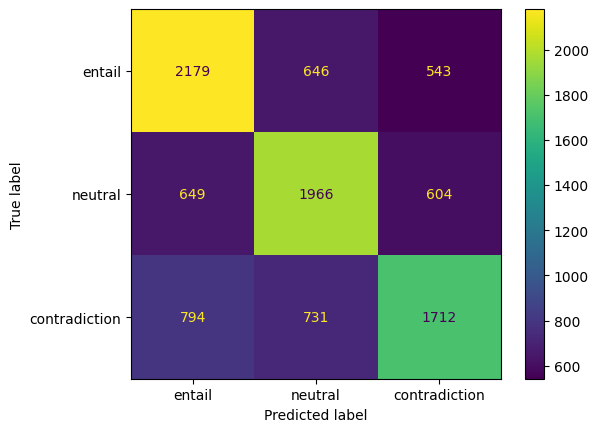

In [24]:
majority_ensemble = Ensemble([model1, model2, model3], majority_strategy)
y_true, y_pred = predict(majority_ensemble, test_dl)
score(y_true, y_pred)

Another common strategy is soft voting, where the predicted class is decided by combining the probabilities predicted by each model.

In [27]:
def avg_strategy(all_predictions: list[torch.Tensor]):
    # Get predicted classes
    all_predictions = torch.stack(all_predictions)  # Shape: (models, batch_size, classes)
    avg_prediction = all_predictions.sum(dim=0) # /len(pred_batches) <-- not needed for argmax
    pred_classes = avg_prediction.argmax(dim=-1)
    return pred_classes

               precision    recall  f1-score   support

       entail       0.63      0.62      0.63      3368
      neutral       0.58      0.63      0.60      3219
contradiction       0.60      0.56      0.58      3237

     accuracy                           0.60      9824
    macro avg       0.60      0.60      0.60      9824
 weighted avg       0.60      0.60      0.60      9824

Accuracy: 0.6037255700325733
F1-Score: 0.6031637972797365


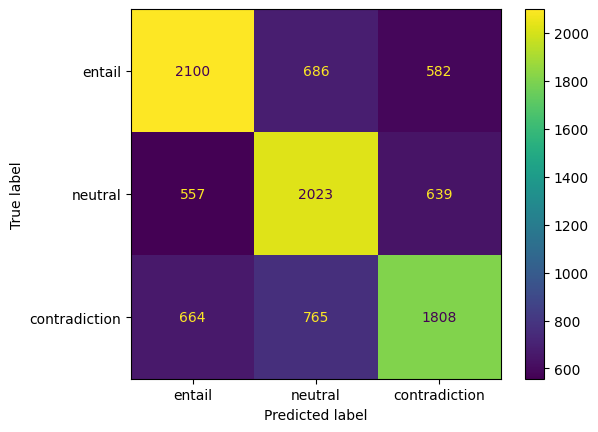

In [28]:
soft_ensemble = Ensemble([model1, model2, model3], avg_strategy)
y_true, y_pred = predict(soft_ensemble, test_dl)
score(y_true, y_pred)

## Distillation

With distillation, we train a smaller student model to mimic the predictions of a larger teacher model.
Instead of just learning the right labels, the student learns the full distribution from the teacher.

In [29]:
def distill(teacher_ensemble: Ensemble, student_model: Model, train_dl, val_dl, epochs=10, max_steps_per_epoch=None):
    teacher_ensemble.eval()
    optimizer = torch.optim.Adam(student_model.parameters(), lr=1e-3)
    
    # KLDivLoss inputs: student log-probs and teacher probs
    criterion = nn.KLDivLoss(reduction='batchmean') 

    losses = []
    f1_scores = []
    epoch_loss = 0
    steps = 0
    samples = 0
    for epoch in tqdm(range(epochs), total=epochs):
        for i, batch in enumerate(train_dl):            
            student_model.train()
            optimizer.zero_grad()
            # Student predictions
            student_log_probs = student_model.log_prob(batch['input_ids']) 
            # Reference predictions 
            with torch.no_grad():
                teacher_probs = teacher_ensemble.prob(batch['input_ids'])
            loss = criterion(student_log_probs, teacher_probs)
            loss.backward()
            optimizer.step()
            epoch_loss += loss.sum().item()
            steps += 1
            samples += batch['input_ids'].size(0)

            if max_steps_per_epoch is not None and steps >= max_steps_per_epoch:
                break
        losses.append(epoch_loss / samples)
        f1_scores.append(f1_score(student_model, val_dl))
        epoch_loss = 0
        steps = 0
        samples = 0
    return student_model, losses, f1_scores

  0%|          | 0/20 [00:00<?, ?it/s]

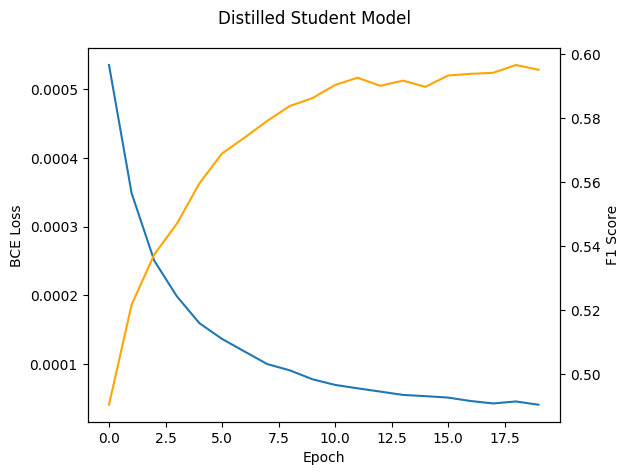

               precision    recall  f1-score   support

       entail       0.62      0.61      0.62      3368
      neutral       0.57      0.61      0.59      3219
contradiction       0.59      0.55      0.57      3237

     accuracy                           0.59      9824
    macro avg       0.59      0.59      0.59      9824
 weighted avg       0.59      0.59      0.59      9824

Accuracy: 0.5926302931596091
F1-Score: 0.5921813783815049


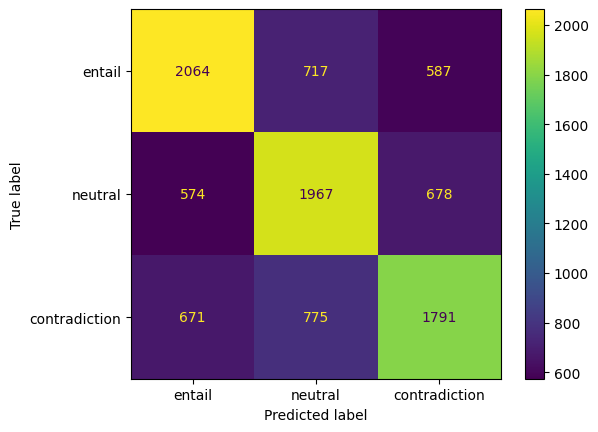

In [30]:
student = Model().to(device)
soft_ensemble = Ensemble([model1, model2, model3], avg_strategy)
student, losses, f1_scores = distill(soft_ensemble, student, train_dl, val_dl, epochs=20, max_steps_per_epoch=10)
plot_loss(losses, f1_scores, title="Distilled Student Model")
y_true, y_pred = predict(student, test_dl)
score(y_true, y_pred)

## Learning the ensemble weights - Extra

We can get creative on how we combine the models, what about learning the combination weights?


In this example we can fit a linear model that weights the predictions of each model (so 3 weights).
Alternatively, we could concatenate the predictions and use another linear model (9 weights in this case).
Or use any other more complex model.

In [37]:
estimators = [model1,model2, model3]
weights = nn.Linear(len(estimators), 1, bias=False).to(device)
weights.weight

Parameter containing:
tensor([[ 0.3032, -0.3643,  0.0503]], device='cuda:0', requires_grad=True)

`weights` is a linear layer without bias that takes as input the probabilities predicted by each model and outputs the weighted average prediction.
We can train it the same way as we trained the models at the beginning. We just have to reshape a bit the data.

In [38]:
def combine(models: list[Model], weights: nn.Module, val_dl, epochs=3):
    weights.eval()
    optimizer = torch.optim.Adam(weights.parameters(), lr=1e-3)
    criterion = nn.CrossEntropyLoss()

    losses = []
    epoch_loss = 0
    steps = 0
    samples = 0
    for epoch in tqdm(range(epochs), total=epochs):
        for i, batch in enumerate(val_dl):            
            weights.train()
            optimizer.zero_grad()
            
            # Model predictions 
            with torch.no_grad():
                probs = []
                for model in models:
                    model.eval()
                    probs.append(model.prob(batch['input_ids']))
                probs = torch.stack(probs) # Shape: (models, batch_size, classes)
                probs = probs.permute(1, 2, 0) # Shape: (batch_size, classes, models)
            pred = weights(probs).squeeze(-1) # Shape: (batch_size, classes)
            loss = criterion(pred, batch['label'].to(device))
            loss.backward()
            optimizer.step()
            epoch_loss += loss.sum().item()
            steps += 1
            samples += batch['input_ids'].size(0)

        losses.append(epoch_loss / samples)
        epoch_loss = 0
        steps = 0
        samples = 0
    return weights, losses

  0%|          | 0/3 [00:00<?, ?it/s]

Text(0, 0.5, 'Loss')

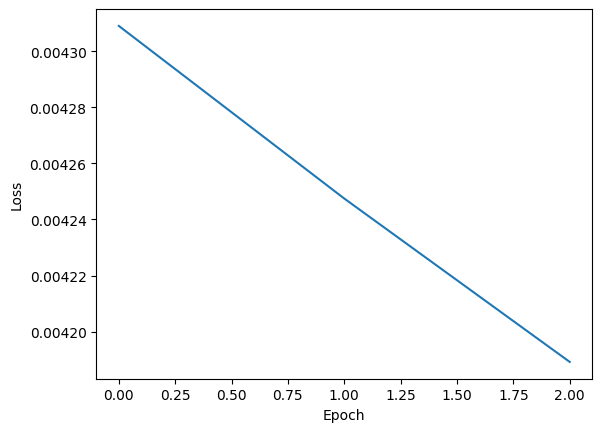

In [39]:
combined_weights, losses = combine(estimators, weights, val_dl)
plt.plot(losses)
plt.xlabel('Epoch')
plt.ylabel('Loss')

In [40]:
def weighted_strategy(pred_batches: list[torch.Tensor], weights: nn.Module):
    probs = torch.stack(pred_batches) # Shape: (models, batch_size, classes)
    probs = probs.permute(1, 2, 0) # Shape: (batch_size, classes, models)
    avg_prediction = weights(probs).squeeze(-1) # Shape: (batch_size, classes)
    pred_classes = avg_prediction.argmax(dim=-1)
    return pred_classes

               precision    recall  f1-score   support

       entail       0.56      0.66      0.61      3368
      neutral       0.58      0.50      0.54      3219
contradiction       0.54      0.52      0.53      3237

     accuracy                           0.56      9824
    macro avg       0.56      0.56      0.56      9824
 weighted avg       0.56      0.56      0.56      9824

Accuracy: 0.5610749185667753
F1-Score: 0.5581468596529248


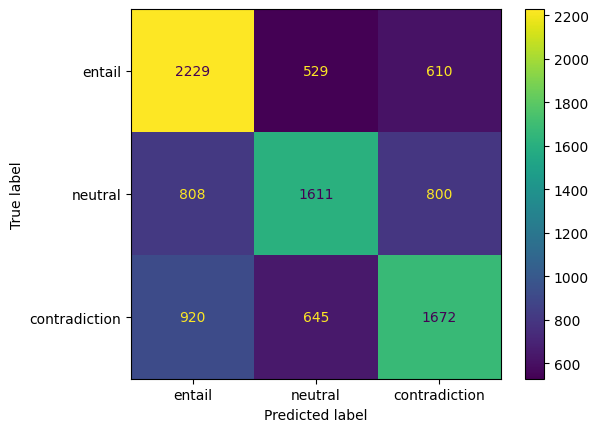

In [41]:
weighted_ensemble = Ensemble([model1, model2, model3], lambda preds: weighted_strategy(preds, combined_weights))
y_true, y_pred = predict(weighted_ensemble, test_dl)
score(y_true, y_pred)

In [42]:
combined_weights.weight

Parameter containing:
tensor([[ 0.4171, -0.2499,  0.1644]], device='cuda:0', requires_grad=True)